In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import sys
import cv2
import matplotlib
from subprocess import check_output
import tensorflow as tf
tf.config.list_physical_devices('GPU')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,Input, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
#list the files in the input directory
#print(os.listdir("../input"))
#print(check_output(["ls", "../input"]).decode("utf8")) #trainLabels.csv
#print(check_output(["pwd", ""]).decode("utf8")) # /kaggle/working/
#classes : 0 - No DR, 1 - Mild, 2 - Moderate, 3 - Severe, 4 - Proliferative DR
def classes_to_int(label):
    # label = classes.index(dir)
    label = label.strip()
    if label == "No DR":  return 0
    if label == "Mild":  return 1
    if label == "Moderate":  return 2
    if label == "Severe":  return 3
    if label == "Proliferative DR":  return 4
    print("Invalid Label", label)
    return 5

def int_to_classes(i):
    if i == 0: return "No DR"
    elif i == 1: return "Mild"
    elif i == 2: return "Moderate"
    elif i == 3: return "Severe"
    elif i == 4: return "Proliferative DR"
    print("Invalid class ", i)
    return "Invalid Class"

In [2]:
NUM_CLASSES = 5
# we need images of same size so we convert them into the size
WIDTH = 128
HEIGHT = 128
DEPTH = 3
inputShape = (HEIGHT, WIDTH, DEPTH)
# initialize number of epochs to train for, initial learning rate and batch size
EPOCHS = 15
INIT_LR = 1e-3
BS = 32
#global variables
ImageNameDataHash = {}
uniquePatientIDList = []

In [3]:
def readTrainData(trainDir):
    global ImageNameDataHash
    # loop over the input images
    ImageNameDataHash = {} 
    images = os.listdir(trainDir)
    print("Number of files in " + trainDir + " is " + str(len(images)))
    for imageFileName in images:
        if (imageFileName == "trainLabels.csv"):
            continue
        # load the image, pre-process it, and store it in the data list
        imageFullPath = os.path.join(trainDir, imageFileName)
#         print(imageFullPath)
        img = load_img(imageFullPath)
        arr = img_to_array(img)  # Numpy array with shape (233,233,3)
        dim1 = arr.shape[0]
        dim2 = arr.shape[1]
        dim3 = arr.shape[2]
        if (dim1 < HEIGHT or dim2 < WIDTH or dim3 < DEPTH):
            print("Error image dimensions are less than expected "+str(arr.shape))
        arr = cv2.resize(arr, (HEIGHT,WIDTH)) #Numpy array with shape (HEIGHT, WIDTH,3)
        #print(arr.shape) # 128,128,3
        dim1 = arr.shape[0]
        dim2 = arr.shape[1]
        dim3 = arr.shape[2]
        if (dim1 != HEIGHT or dim2 != WIDTH or dim3 != DEPTH):
            print("Error after resize, image dimensions are not equal to expected "+str(arr.shape))
        #print(type(arr))
        # scale the raw pixel intensities to the range [0, 1] - TBD TEST
        arr = np.array(arr, dtype="float") / 255.0
        imageFileName = imageFileName.replace('.jpeg','')
        ImageNameDataHash[str(imageFileName)] = np.array(arr) 
    return

In [4]:
from datetime import datetime
print("Loading images at..."+ str(datetime.now()))
sys.stdout.flush()
path = os.path.join("D:", "diabetic-retinopathy-detection", "resized_train")
if not os.path.exists(path):
    raise FileNotFoundError(f"The specified path does not exist: {path}")
readTrainData(path)
# print(os.listdir(path))
print("Loaded " + str(len(ImageNameDataHash)) + " images at..."+ str(datetime.now()))

Loading images at...2024-12-16 15:41:17.505353
Number of files in D:diabetic-retinopathy-detection\resized_train is 3615
Loaded 3615 images at...2024-12-16 15:55:05.031831


In [5]:
#csv contains image	level
#10_left 0
#10_right 0
import csv
def readTrainCsv():
    path = os.path.join("D:", "diabetic-retinopathy-detection", "trainLabels.csv")
    raw_df = pd.read_csv(path)
    print(type(raw_df)) #<class 'pandas.core.frame.DataFrame'>
    row_count=raw_df.shape[0] #gives number of row count row_count=35126 
    col_count=raw_df.shape[1] #gives number of col count col count=2
    print("row_count="+str(row_count)+" col count="+str(col_count))
    raw_df["PatientID"] = ''
    header_list = list(raw_df.columns)
    print(header_list) # ['image', 'level', 'PatientID']
    # double check if level of left and right are same or not
    ImageLevelHash = {}
    patientIDList = []
    for index, row in raw_df.iterrows():
        # 0 is image, 1 is level, 2 is PatientID, 3 is data
        key = row[0] + ''
        patientID = row[0] + ''
        patientID = patientID.replace('_right','')
        patientID = patientID.replace('_left','')
        #print("Adding patient ID"+ patientID)
        raw_df.at[index, 'PatientID'] = patientID
        patientIDList.append(patientID)
        ImageLevelHash[key] = str(row[1]) # level
                
    global uniquePatientIDList
    uniquePatientIDList = sorted(set(patientIDList))
    count=0;
    for patientID in uniquePatientIDList:
        left_level = ImageLevelHash[str(patientID+'_left')]
        right_level = ImageLevelHash[str(patientID+'_right')]
        #right_exists = str(patientID+'_right') in raw_df.values
        if (left_level != right_level):
            count = count+1
            #print("Warning for patient="+ str(patientID) + " left_level=" + left_level+ " right_level=" +right_level)
    print("count of images with both left and right eye level not matching="+str(count)) # 2240
    print("number of unique patients="+str(len(uniquePatientIDList))) # 17563
    return raw_df

In [6]:
random.seed(10)
print("Reading trainLabels.csv...")
df = readTrainCsv()

Reading trainLabels.csv...
<class 'pandas.core.frame.DataFrame'>
row_count=35126 col count=2
['image', 'level', 'PatientID']


C:\Users\ayush\AppData\Local\Temp\ipykernel_14464\3297990645.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  key = row[0] + ''
C:\Users\ayush\AppData\Local\Temp\ipykernel_14464\3297990645.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patientID = row[0] + ''
C:\Users\ayush\AppData\Local\Temp\ipykernel_14464\3297990645.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ImageLevelHash[key] = str(row[1]) # level


count of images with both left and right eye level not matching=2240
number of unique patients=17563


In [7]:
for i in range(0,10):
    s = df.loc[df.index[i], 'PatientID'] # get patient id of patients
    print(str(i) + " patient's patientID="+str(s))

0 patient's patientID=10
1 patient's patientID=10
2 patient's patientID=13
3 patient's patientID=13
4 patient's patientID=15
5 patient's patientID=15
6 patient's patientID=16
7 patient's patientID=16
8 patient's patientID=17
9 patient's patientID=17


In [8]:
# df has 3 columns ['image', 'level', 'PatientID']
keepImages =  list(ImageNameDataHash.keys())
df = df[df['image'].isin(keepImages)]
print(len(df)) # 1000

3615


In [9]:
#convert hash to dataframe
imageNameArr = []
dataArr = []
for index, row in df.iterrows():
    key = str(row[0])
    if key in ImageNameDataHash:
        imageNameArr.append(key)
        dataArr.append(np.array(ImageNameDataHash[key])) # np.array

df2 = pd.DataFrame({'image': imageNameArr, 'data': dataArr})
df2_header_list = list(df2.columns) 
print(df2_header_list) # ['image', 'data']
print(len(df2)) # 1000
#print(df2.describe(include='all'))
#print(df2.sample(3)) # 3 rows x 2 columns

C:\Users\ayush\AppData\Local\Temp\ipykernel_14464\2163714219.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  key = str(row[0])


['image', 'data']
3615


In [10]:
if len(df) != len(df2):
    print("Error length of df != df2")
    
for idx in range(0,len(df)):
    if (df.loc[df.index[idx], 'image'] != df2.loc[df2.index[idx], 'image']):
        print("Error " + df.loc[df.index[idx], 'image'] +"==" + df2.loc[df2.index[idx], 'image'])
        
print(df2.dtypes)
print(df.dtypes)

image    object
data     object
dtype: object
image        object
level         int64
PatientID    object
dtype: object


In [11]:
df = pd.merge(df2, df, left_on='image', right_on='image', how='outer')
df_header_list = list(df.columns) 
print(df_header_list) # 'image', 'data', level', 'PatientID'
print(len(df)) # 1000
print(df.sample())

['image', 'data', 'level', 'PatientID']
3615
           image                                               data  level  \
2362  3429_right  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      0   

     PatientID  
2362      3429  


[[[0.         0.         0.        ]
  [0.00245098 0.00539216 0.00245098]
  [0.00392157 0.00392157 0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.00370711 0.00370711 0.00370711]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.00392157 0.00392157 0.00392157]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]


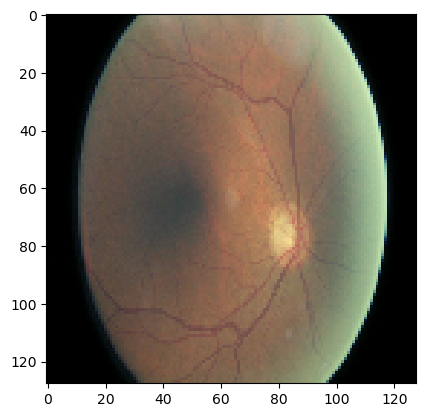

Sample Image


In [12]:
sample0 = df.loc[df.index[0], 'data']
print(sample0)
print(type(sample0)) # <class 'numpy.ndarray'>
print(sample0.shape) # 128,128,3
from matplotlib import pyplot as plt
plt.imshow(sample0, interpolation='nearest')
plt.show()
print("Sample Image")

In [13]:
X = df['data']
Y = df['level']
# scale the raw pixel intensities to the range [0, 1]
#print(type(X)) # 'pandas.core.series.Series'
#X = np.array(X, dtype="float") / 255.0 -- TBD moved to top
Y = np.array(Y)
# convert the labels from integers to vectors
Y =  to_categorical(Y, num_classes=NUM_CLASSES)

In [14]:
# partition the data into training and testing splits using 75% training and 25% for validation
print("Parttition data into 75:25...")
sys.stdout.flush()
print("Unique patients in dataframe df=" + str(df.PatientID.nunique())) # 500
unique_ids = df.PatientID.unique()
print('unique_ids shape='+ str(len(unique_ids))) #500

# Refer https://www.kaggle.com/kmader/tf-data-tutorial-with-retina-and-keras
train_ids, valid_ids = train_test_split(unique_ids, test_size = 0.25, random_state = 10) #stratify = rr_df['level'])
trainid_list = train_ids.tolist()
print('trainid_list shape=', str(len(trainid_list))) # 375

traindf = df[df.PatientID.isin(trainid_list)]
valSet = df[~df.PatientID.isin(trainid_list)]

Parttition data into 75:25...
Unique patients in dataframe df=1955
unique_ids shape=1955
trainid_list shape= 1466


In [15]:
print(traindf.head())
print(valSet.head())

traindf = traindf.reset_index(drop=True)
valSet = valSet.reset_index(drop=True)

print(traindf.head())
print(valSet.head())

        image                                               data  level  \
0   1000_left  [[[0.0, 0.0, 0.0], [0.0024509803921568627, 0.0...      0   
1  1000_right  [[[0.0024509803921568627, 0.005392156862745098...      0   
4   1008_left  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      3   
5    100_left  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      0   
6   100_right  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      0   

  PatientID  
0      1000  
1      1000  
4      1008  
5       100  
6       100  
         image                                               data  level  \
2    1002_left  [[[0.00045955882352941176, 0.00045955882352941...      3   
3   1002_right  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      2   
18   1027_left  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      1   
19  1027_right  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      0   
20   1029_left  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      0   

   Patie

In [16]:
trainX = traindf['data']
trainY = traindf['level']

valX = valSet['data']
valY = valSet['level']

#(trainX, valX, trainY, valY) = train_test_split(X,Y,test_size=0.25, random_state=10)
print('trainX shape=', trainX.shape[0], 'valX shape=', valX.shape[0]) # 750, 250

trainX shape= 2712 valX shape= 903


In [17]:
trainY =  to_categorical(trainY, num_classes=NUM_CLASSES)
valY =  to_categorical(valY, num_classes=NUM_CLASSES)

In [18]:
#construct the image generator for data augmentation
print("Generating images...")
sys.stdout.flush()
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, \
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,\
    horizontal_flip=True, fill_mode="nearest")

Generating images...


In [19]:
print("calculating steps per epoch")
steps_per_epoch=len(trainX) // BS if len(trainX) % BS == 0 else (len(trainX) // BS) + 1
print("Steps per epoch=",steps_per_epoch)

calculating steps per epoch
Steps per epoch= 85


In [20]:
def createModel():
    # first set of CONV => RELU => MAX POOL layers
    model = Sequential([Input(shape=inputShape),Conv2D(32, (3, 3), padding='same', activation='relu')])
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    # returns our fully constructed deep learning + Keras image classifier 
    lr_schedule = ExponentialDecay(
    initial_learning_rate=INIT_LR,
    decay_steps=steps_per_epoch * EPOCHS,
    decay_rate=0.96,  
    staircase=False    
    )
    opt = Adam(learning_rate=lr_schedule)
    # opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
    # use binary_crossentropy if there are two classes
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model

In [21]:
print("Reshaping trainX at..."+ str(datetime.now()))
#print(trainX.sample()) 
print(type(trainX)) # <class 'pandas.core.series.Series'>
print(trainX.shape) # (750,)
from numpy import zeros
Xtrain = np.memmap('Xtrain.dat', dtype=np.float32, mode='w+', shape=(trainX.shape[0], HEIGHT, WIDTH, DEPTH))
for i in range(trainX.shape[0]): # 0 to traindf Size -1
    Xtrain[i] = trainX[i]
print(Xtrain.shape) # (750,128,128,3)
print("Reshaped trainX at..."+ str(datetime.now()))

Reshaping trainX at...2024-12-16 15:55:45.966065
<class 'pandas.core.series.Series'>
(2712,)
(2712, 128, 128, 3)
Reshaped trainX at...2024-12-16 15:55:46.696060


In [22]:
print("Reshaping valX at..."+ str(datetime.now()))
print(type(valX)) # <class 'pandas.core.series.Series'>
print(valX.shape) # (250,)
from numpy import zeros
Xval = np.memmap('Xval.dat', dtype=np.float32, mode='w+', shape=(valX.shape[0], HEIGHT, WIDTH, DEPTH))
for i in range(valX.shape[0]): # 0 to traindf Size -1
    Xval[i] = valX[i]
print(Xval.shape) # (250,128,128,3)
print("Reshaped valX at..."+ str(datetime.now()))

Reshaping valX at...2024-12-16 15:55:46.713412
<class 'pandas.core.series.Series'>
(903,)
(903, 128, 128, 3)
Reshaped valX at...2024-12-16 15:55:47.223325


In [23]:
# initialize the model
print("compiling model...")
sys.stdout.flush()
model = createModel()

# print the summary of model

# from keras.utils import print_summary
# print_summary(model, line_length=None, positions=None, print_fn=None)

# add some visualization

# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot
# SVG(model_to_dot(model).create(prog='dot', format='svg'))

compiling model...


In [24]:
# train the network
print("training network...")
sys.stdout.flush()
#class_mode ='categorical', # 2D one-hot encoded labels
train_dataset = tf.data.Dataset.from_tensor_slices((Xtrain, trainY))
train_dataset = train_dataset.shuffle(buffer_size=len(Xtrain)).batch(BS).repeat()

val_dataset = tf.data.Dataset.from_tensor_slices((Xval, valY)).batch(BS)

H = model.fit(train_dataset, \
    validation_data=val_dataset, \
    steps_per_epoch=steps_per_epoch, \
    epochs=EPOCHS, verbose=1)

# save the model to disk
print("Saving model to disk")
sys.stdout.flush()
model.save("C:/Users/ayush/mymodel.keras")

training network...
Epoch 1/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 79s 854ms/step - accuracy: 0.6989 - loss: 0.9697 - val_accuracy: 0.7542 - val_loss: 0.8528
Epoch 2/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 69s 813ms/step - accuracy: 0.7470 - loss: 0.8581 - val_accuracy: 0.7542 - val_loss: 0.8617
Epoch 3/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 65s 770ms/step - accuracy: 0.7313 - loss: 0.8875 - val_accuracy: 0.7542 - val_loss: 0.8480
Epoch 4/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 67s 792ms/step - accuracy: 0.7497 - loss: 0.8592 - val_accuracy: 0.7542 - val_loss: 0.8325
Epoch 5/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.7419 - loss: 0.8584 - val_accuracy: 0.7542 - val_loss: 0.8407
Epoch 6/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.7406 - loss: 0.8553 - val_accuracy: 0.7542 - val_loss: 0.8353
Epoch 7/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.7151 - loss: 0.9156 - val_accuracy: 0.7542 - val_loss: 0.8470
Epoch 8/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 83s 983ms/step - accuracy: 0.7433 - loss: 0.863

In [25]:
# set the matplotlib backend so figures can be saved in the background
# plot the training loss and accuracy
# print(H.history.keys())
# print(len(H.history["loss"]))
sys.stdout.flush()
matplotlib.use("Agg")
matplotlib.pyplot.style.use("ggplot")
matplotlib.pyplot.figure()
N = len(H.history["loss"])
matplotlib.pyplot.plot(np.arange(0, N), H.history["loss"], label="train_loss")
matplotlib.pyplot.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
matplotlib.pyplot.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
matplotlib.pyplot.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
matplotlib.pyplot.title("Training Loss and Accuracy on diabetic retinopathy detection")
matplotlib.pyplot.xlabel("Epoch #")
matplotlib.pyplot.ylabel("Loss/Accuracy")
matplotlib.pyplot.legend(loc="lower left")
matplotlib.pyplot.savefig("plot.png")

##Code to  test the Model Prediction⬇️⬇️

In [2]:
from keras.models import load_model
import cv2
from tensorflow.keras.preprocessing.image import array_to_img,img_to_array,load_img
import numpy as np
model= load_model(r"C:\Users\ayush\mymodel.keras")
img_left = load_img(r"D:\diabetic-retinopathy-detection\train\16_left.jpeg")
img_left_arr = img_to_array(img_left)
img_left_arr
arr =cv2.resize(img_left_arr,(128,128))
arr1 = np.array (arr,dtype="float")/255.0
arr1 = np.expand_dims(arr1,axis=0)
pred = model.predict(arr1)
# pred = np.array([[0.808672, 0.9700952, 1.760291, 2.01291793, 0.01379761]])
y_pred=np.argmax(pred,axis=1)
print(pred)
# int_to_classes(y_pred[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
[[0.77503145 0.0349987  0.17071979 0.006066   0.01318403]]
